<a href="https://colab.research.google.com/github/mjmaher987/Stock-Prediction-Using-ML/blob/main/Codes/Stock-08302023-0833.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Reshape, Flatten, LSTM
import yfinance as yf
import matplotlib.pyplot as plt

## Configs

In [2]:
Configs = {
    "training_percent" : 0.8,
    "window_size" : 5,
    "epoch_number" : 50
}

## Preprocessing

In [3]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def get_history_from_yf(self):
        t = yf.Ticker(self.ticker)
        return t.history(period=self.period)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [4]:
etl_data = ETL('EURUSD=X')
history = etl_data.get_history_from_yf()

data = pd.DataFrame(
    {
        'open': pd.Series([x for x in history.Open]),
        'high': pd.Series([x for x in history.High]),
        'low': pd.Series([x for x in history.Low]),
        'close': pd.Series([x for x in history.Close]),
        'volume': pd.Series([x for x in history.Volume]),
    }
)

# Preprocessing
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Splitting into training and testing sets
train_size = int(Configs['training_percent'] * len(data))
train_data, test_data = data[:train_size], data[train_size:]


# NBeats
window_size_NBeats = Configs['window_size']
X_NBeats, y_NBeats = [], []
for i in range(len(data) - window_size_NBeats):
    X_NBeats.append(data['close'][i:i+window_size_NBeats])
    y_NBeats.append(data['close'][i+window_size_NBeats])
X_NBeats = np.array(X_NBeats)
y_NBeats = np.array(y_NBeats)

train_size_NBeats = int(Configs['training_percent']  * len(X_NBeats))
train_X_NBeats, test_X_NBeats = X_NBeats[:train_size_NBeats], X_NBeats[train_size_NBeats:]
train_y_NBeats, test_y_NBeats = y_NBeats[:train_size_NBeats], y_NBeats[train_size_NBeats:]


## NHeats
X_NHeats = data[['open', 'high', 'low', 'volume']].values
y_NHeats = data['close'].values

train_size_NHeats = int(Configs['training_percent'] * len(X_NHeats))
val_size_NHeats = int((1-Configs['training_percent'])/2 * len(X_NHeats))
train_X_NHeats, test_X_NHeats, train_y_NHeats, test_y_NHeats = X_NHeats[:train_size_NHeats], X_NHeats[train_size_NHeats:], y_NHeats[:train_size_NHeats], y_NHeats[train_size_NHeats:]
train_X_NHeats, val_X_NHeats, train_y_NHeats, val_y_NHeats = train_X_NHeats[:train_size_NHeats - val_size_NHeats], train_X_NHeats[train_size_NHeats - val_size_NHeats:], \
                                  train_y_NHeats[:train_size_NHeats - val_size_NHeats], train_y_NHeats[train_size_NHeats - val_size_NHeats:]

scaler_X_NHeats = MinMaxScaler()
train_X_NHeats = scaler_X_NHeats.fit_transform(train_X_NHeats)
val_X_NHeats = scaler_X_NHeats.transform(val_X_NHeats)
test_X_NHeats = scaler_X_NHeats.transform(test_X_NHeats)

scaler_y_NHeats = MinMaxScaler()
train_y_NHeats = scaler_y_NHeats.fit_transform(train_y_NHeats.reshape(-1, 1)).flatten()
val_y_NHeats = scaler_y_NHeats.transform(val_y_NHeats.reshape(-1, 1)).flatten()
test_y_NHeats = scaler_y_NHeats.transform(test_y_NHeats.reshape(-1, 1)).flatten()

## RNN
train_X_rnn = train_X_NHeats.reshape(train_X_NHeats.shape[0], train_X_NHeats.shape[1], 1)
train_y_rnn = train_y_NHeats
val_X_rnn = val_X_NHeats.reshape(val_X_NHeats.shape[0], val_X_NHeats.shape[1], 1)
val_y_rnn = val_y_NHeats
test_X_rnn = test_X_NHeats.reshape(test_X_NHeats.shape[0], test_X_NHeats.shape[1], 1)
test_y_rnn = scaler_y_NHeats.transform(test_y_NHeats.reshape(-1, 1)).flatten()


## LSTM
train_X_lstm = train_X_NHeats.reshape(train_X_NHeats.shape[0], train_X_NHeats.shape[1], 1)
test_X_lstm = test_X_NHeats.reshape(test_X_NHeats.shape[0], test_X_NHeats.shape[1], 1)
test_y_lstm = test_y_NHeats
train_y_lstm = train_y_NHeats

## Experiments

### I

In [5]:
def calculate_ichimoku_cloud(df):
    # Tenkan-sen (Conversion Line) - Average of the highest high and lowest low over a certain period
    df['tenkan_sen'] = (df['high'].rolling(window=9).max() + df['low'].rolling(window=9).min()) / 2

    # Kijun-sen (Base Line) - Average of the highest high and lowest low over a longer period
    df['kijun_sen'] = (df['high'].rolling(window=26).max() + df['low'].rolling(window=26).min()) / 2

    # Senkou Span A (Leading Span A) - Average of the Tenkan-sen and Kijun-sen, shifted forward
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)

    # Senkou Span B (Leading Span B) - Average of the highest high and lowest low over an even longer period, shifted forward
    df['senkou_span_b'] = ((df['high'].rolling(window=52).max() + df['low'].rolling(window=52).min()) / 2).shift(26)

    # Chikou Span (Lagging Span) - Close price shifted backward
    df['chikou_span'] = df['close'].shift(-26)

    return df[['tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span']]

# Calculate Ichimoku Cloud components
data_with_cloud = calculate_ichimoku_cloud(data)

def ichimoku_trading_strategy(df):
    signals = []
    for i in range(len(df)):
        if data['close'][i] > df['senkou_span_a'][i] and data['close'][i] > df['senkou_span_b'][i]:
            signals.append('Buy')
        elif data['close'][i] < df['senkou_span_a'][i] and data['close'][i] < df['senkou_span_b'][i]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Generate trading signals using the Ichimoku-based strategy
trading_signals = ichimoku_trading_strategy(data_with_cloud)

# Print the trading signals
for i, signal in enumerate(trading_signals):
    print(f"Day {i + 1}: {signal}")

Streaming output truncated to the last 5000 lines.
Day 125: Sell
Day 126: Sell
Day 127: Sell
Day 128: Sell
Day 129: Sell
Day 130: Sell
Day 131: Sell
Day 132: Sell
Day 133: Sell
Day 134: Sell
Day 135: Sell
Day 136: Sell
Day 137: Sell
Day 138: Sell
Day 139: Sell
Day 140: Sell
Day 141: Sell
Day 142: Sell
Day 143: Sell
Day 144: Sell
Day 145: Sell
Day 146: Sell
Day 147: Sell
Day 148: Sell
Day 149: Sell
Day 150: Sell
Day 151: Sell
Day 152: Sell
Day 153: Sell
Day 154: Sell
Day 155: Sell
Day 156: Sell
Day 157: Sell
Day 158: Sell
Day 159: Sell
Day 160: Sell
Day 161: Sell
Day 162: Sell
Day 163: Sell
Day 164: Sell
Day 165: Sell
Day 166: Sell
Day 167: Sell
Day 168: Sell
Day 169: Sell
Day 170: Sell
Day 171: Sell
Day 172: Sell
Day 173: Sell
Day 174: Sell
Day 175: Sell
Day 176: Sell
Day 177: Sell
Day 178: Sell
Day 179: Sell
Day 180: Sell
Day 181: Sell
Day 182: Sell
Day 183: Sell
Day 184: Sell
Day 185: Sell
Day 186: Sell
Day 187: Sell
Day 188: Sell
Day 189: Sell
Day 190: Sell
Day 191: Sell
Day 192: Se

In [6]:
data_with_cloud

,tenkan_sen,kijun_sen,senkou_span_a,senkou_span_b,chikou_span
0,NaN,NaN,NaN,NaN,0.488883
1,NaN,NaN,NaN,NaN,0.476354
2,NaN,NaN,NaN,NaN,0.497324
3,NaN,NaN,NaN,NaN,0.510457
4,NaN,NaN,NaN,NaN,0.492002
...,...,...,...,...,...
5119,1.088167,1.101632,1.104896,1.09637,NaN
5120,1.085818,1.095935,1.107506,1.09637,NaN
5121,1.085070,1.095935,1.109112,1.09637,NaN
5122,1.084935,1.095935,1.109967,1.09637,NaN


###NBEATS

In [7]:
# Build N-BEATS model
def build_nbeats(input_shape, output_shape, num_blocks=4, num_neurons=128):
    inputs = Input(shape=input_shape)
    x = inputs
    forecasts = []
    for _ in range(num_blocks):
        for _ in range(4):  # Directly following the N-BEATS architecture
            x = Dense(num_neurons, activation='relu')(x)
        forecast = Dense(output_shape[0])(x)
        forecasts.append(forecast)
    outputs = forecasts[0]  # Use the forecast from the first block as output
    model = Model(inputs, outputs)
    return model

input_shape = (window_size_NBeats, 1)
output_shape = (1,)
nbeats_model = build_nbeats(input_shape, output_shape)
nbeats_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train N-BEATS model
nbeats_model.fit(train_X_NBeats, train_y_NBeats, epochs=Configs['epoch_number'] , batch_size=32, verbose=1)

# Make predictions using the trained model
test_predictions_nbeats = nbeats_model.predict(test_X_NBeats)


Epoch 1/50
128/128 [==============================] - 4s 10ms/step - loss: 0.0481
Epoch 2/50
128/128 [==============================] - 1s 9ms/step - loss: 0.0357
Epoch 3/50
128/128 [==============================] - 1s 10ms/step - loss: 0.0354
Epoch 4/50
128/128 [==============================] - 1s 11ms/step - loss: 0.0355
Epoch 5/50
128/128 [==============================] - 2s 12ms/step - loss: 0.0353
Epoch 6/50
128/128 [==============================] - 2s 13ms/step - loss: 0.0354
Epoch 7/50
128/128 [==============================] - 1s 11ms/step - loss: 0.0353
Epoch 8/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0358
Epoch 9/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0354
Epoch 10/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0353
Epoch 11/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0354
Epoch 12/50
128/128 [==============================] - 1s 5ms/step - loss: 0.0355
Epoch 13/50
128/128

In [8]:
reshaped_test_predictions_nbeats = test_predictions_nbeats[:, -1, :]

In [9]:
mae = mean_absolute_error(test_y_NBeats, reshaped_test_predictions_nbeats)
rmse = mean_squared_error(test_y_NBeats, reshaped_test_predictions_nbeats, squared=False)
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.22711698429586508
Root Mean Squared Error: 0.2465658317536553


###NHEATS

In [10]:
# NHITS Model
def build_nhits(input_shape):
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    return model

nhits_model = build_nhits(train_X_NHeats.shape[1])
nhits_model.compile(optimizer='adam', loss='mean_squared_error')

nhits_model.fit(train_X_NHeats, train_y_NHeats, epochs=Configs['epoch_number'], batch_size=32, validation_data=(val_X_NHeats, val_y_NHeats), verbose=1)

nhits_predictions = nhits_model.predict(test_X_NHeats)

# Calculate MAE and RMSE for NHITS
nhits_mae = mean_absolute_error(test_y_NHeats, nhits_predictions)
nhits_rmse = mean_squared_error(test_y_NHeats, nhits_predictions, squared=False)
print(f"NHITS Mean Absolute Error: {nhits_mae}")
print(f"NHITS Root Mean Squared Error: {nhits_rmse}")

Epoch 1/50
113/113 [==============================] - 1s 4ms/step - loss: 0.0109 - val_loss: 8.7214e-05
Epoch 2/50
113/113 [==============================] - 0s 2ms/step - loss: 9.8732e-05 - val_loss: 8.1886e-06
Epoch 3/50
113/113 [==============================] - 0s 3ms/step - loss: 9.0931e-05 - val_loss: 7.0132e-06
Epoch 4/50
113/113 [==============================] - 0s 2ms/step - loss: 8.7860e-05 - val_loss: 1.0359e-05
Epoch 5/50
113/113 [==============================] - 0s 3ms/step - loss: 8.6967e-05 - val_loss: 3.1523e-06
Epoch 6/50
113/113 [==============================] - 0s 2ms/step - loss: 8.5347e-05 - val_loss: 3.9008e-06
Epoch 7/50
113/113 [==============================] - 0s 2ms/step - loss: 8.9577e-05 - val_loss: 3.7410e-06
Epoch 8/50
113/113 [==============================] - 0s 3ms/step - loss: 8.5169e-05 - val_loss: 1.5321e-05
Epoch 9/50
113/113 [==============================] - 0s 2ms/step - loss: 9.0791e-05 - val_loss: 4.7871e-06
Epoch 10/50
113/113 [===========

###RNN

In [11]:
# RNN Model
def build_rnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(input_shape, 1), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model


rnn_model = build_rnn(train_X_rnn.shape[1])
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(train_X_rnn, train_y_rnn, epochs=Configs['epoch_number'], batch_size=32, validation_data=(val_X_rnn, val_y_rnn), verbose=1)


# Evaluate RNN models
rnn_predictions = rnn_model.predict(test_X_rnn)
print(test_X_rnn)

# Calculate MAE and RMSE for RNN
rnn_mae = mean_absolute_error(test_y_rnn, rnn_predictions)
rnn_rmse = mean_squared_error(test_y_rnn, rnn_predictions, squared=False)
print(f"RNN Mean Absolute Error: {rnn_mae}")
print(f"RNN Root Mean Squared Error: {rnn_rmse}")


Epoch 1/50
113/113 [==============================] - 2s 7ms/step - loss: 0.0389 - val_loss: 0.0015
Epoch 2/50
113/113 [==============================] - 1s 6ms/step - loss: 2.4858e-04 - val_loss: 2.9064e-05
Epoch 3/50
113/113 [==============================] - 1s 6ms/step - loss: 1.1664e-04 - val_loss: 1.2887e-05
Epoch 4/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1384e-04 - val_loss: 7.8840e-06
Epoch 5/50
113/113 [==============================] - 1s 6ms/step - loss: 1.1167e-04 - val_loss: 7.8450e-05
Epoch 6/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1368e-04 - val_loss: 8.6688e-06
Epoch 7/50
113/113 [==============================] - 1s 5ms/step - loss: 1.0988e-04 - val_loss: 3.1081e-05
Epoch 8/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1382e-04 - val_loss: 1.4049e-05
Epoch 9/50
113/113 [==============================] - 1s 5ms/step - loss: 1.1256e-04 - val_loss: 1.5130e-05
Epoch 10/50
113/113 [===============

###LSTM

In [12]:
# LSTM Model
def build_lstm(input_shape):
    model = tf.keras.Sequential([
        LSTM(64, input_shape=input_shape, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    return model


lstm_model = build_lstm(train_X_lstm.shape[1:])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

lstm_model.fit(train_X_lstm, train_y_lstm, epochs=Configs['epoch_number'], batch_size=32, verbose=1)

lstm_predictions = lstm_model.predict(test_X_lstm)



# Calculate MAE and RMSE for LSTM
lstm_mae = mean_absolute_error(test_y_lstm, lstm_predictions)
lstm_rmse = mean_squared_error(test_y_lstm, lstm_predictions, squared=False)
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM Root Mean Squared Error: {lstm_rmse}")


Epoch 1/50
113/113 [==============================] - 5s 8ms/step - loss: 0.0710
Epoch 2/50
113/113 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 3/50
113/113 [==============================] - 1s 7ms/step - loss: 1.6149e-04
Epoch 4/50
113/113 [==============================] - 1s 7ms/step - loss: 1.1263e-04
Epoch 5/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0760e-04
Epoch 6/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0604e-04
Epoch 7/50
113/113 [==============================] - 1s 11ms/step - loss: 1.0273e-04
Epoch 8/50
113/113 [==============================] - 1s 11ms/step - loss: 1.0393e-04
Epoch 9/50
113/113 [==============================] - 1s 8ms/step - loss: 1.0125e-04
Epoch 10/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0231e-04
Epoch 11/50
113/113 [==============================] - 1s 7ms/step - loss: 1.0907e-04
Epoch 12/50
113/113 [==============================] - 1s 7ms/step - 

###Transformers

In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)


transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  hist = transformer.fit(etl_data.X_train, etl_data.y_train, batch_size=32, epochs=Configs['epoch_number'], verbose=1, callbacks=callbacks)
  return hist


hist = fit_transformer(transformer_model)

Epoch 1/50
128/128 [==============================] - 15s 49ms/step - loss: 0.1944 - mae: 0.2546 - mape: 20.0483
Epoch 2/50
128/128 [==============================] - 4s 29ms/step - loss: 0.0097 - mae: 0.0776 - mape: 6.1101
Epoch 3/50
128/128 [==============================] - 4s 28ms/step - loss: 0.0078 - mae: 0.0699 - mape: 5.4989
Epoch 4/50
128/128 [==============================] - 5s 36ms/step - loss: 0.0069 - mae: 0.0656 - mape: 5.1539
Epoch 5/50
128/128 [==============================] - 4s 30ms/step - loss: 0.0062 - mae: 0.0623 - mape: 4.9067
Epoch 6/50
128/128 [==============================] - 4s 28ms/step - loss: 0.0056 - mae: 0.0590 - mape: 4.6430
Epoch 7/50
128/128 [==============================] - 4s 31ms/step - loss: 0.0053 - mae: 0.0572 - mape: 4.4959
Epoch 8/50
128/128 [==============================] - 4s 32ms/step - loss: 0.0047 - mae: 0.0543 - mape: 4.2681
Epoch 9/50
128/128 [==============================] - 4s 29ms/step - loss: 0.0043 - mae: 0.0520 - mape: 4.0900

In [15]:
transformer_predictions = transformer_model.predict(etl_data.X_test)

transformer_mae = mean_absolute_error(etl_data.y_test, transformer_predictions)
transformer_rmse = mean_squared_error(etl_data.y_test, transformer_predictions, squared=False)
print(f"Transformer Mean Absolute Error: {transformer_mae}")
print(f"Transformet Mean Squared Error: {transformer_rmse}")


32/32 [==============================] - 1s 15ms/step
Transformer Mean Absolute Error: 0.008805529714569332
Transformet Mean Squared Error: 0.011330946430632772


## Visualizations

In [16]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='EURUSD price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))

  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')

  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')

  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = './result_plots'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

### LSTM

In [21]:
etl_data.X_test.shape

(1016, 5, 1)

In [22]:
lstm_predictions.shape

(1025, 1)

In [ ]:
plot_results(etl_data.X_test, lstm_predictions, etl_data.df, title_suffix='NBeats')

## RNN

In [23]:
rnn_predictions.shape

(1025, 1)

In [ ]:
plot_results(etl_data.X_test, rnn_predictions, etl_data.df, title_suffix='NBeats')

### Transformer

In [24]:
transformer_predictions.shape

(1016, 5)

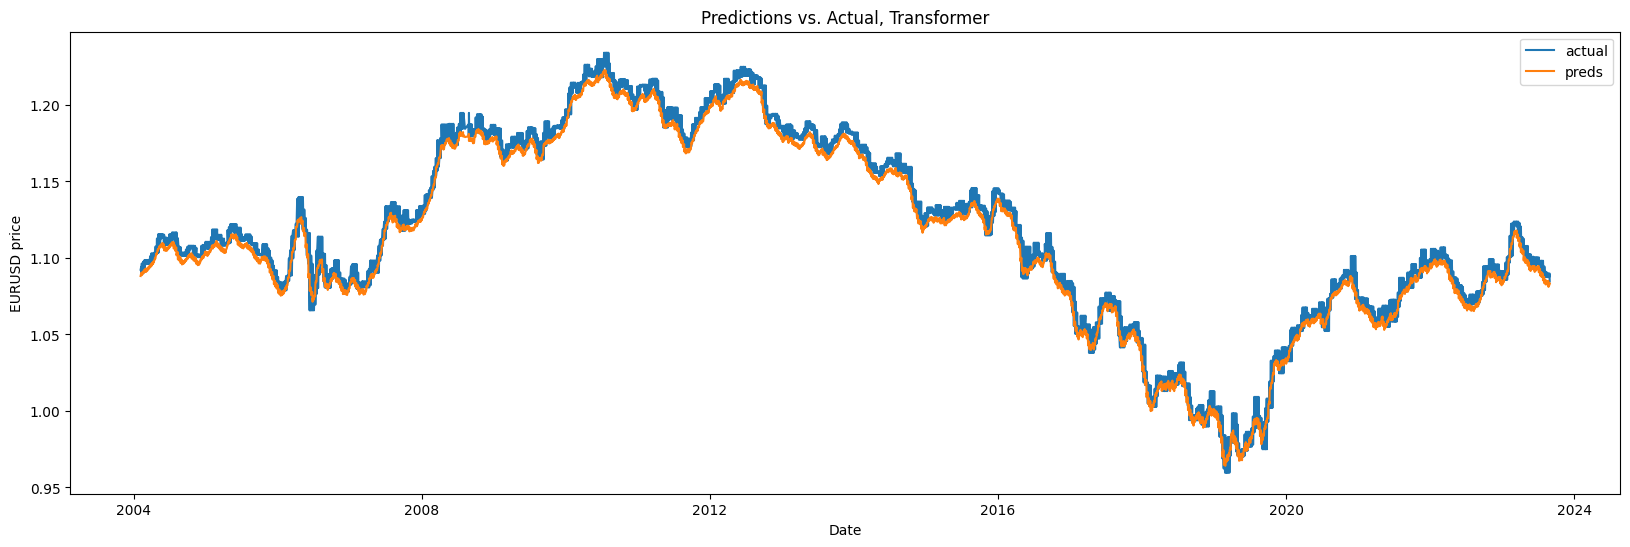

In [25]:
plot_results(etl_data.X_test, transformer_predictions, etl_data.df, title_suffix='Transformer')

Save and serialize models for the bot

In [26]:
# save models for bot usage
nbeats_model.save('./model_dumps/nbeats.keras')
nhits_model.save('./model_dumps/nhits.keras')
rnn_model.save('./model_dumps/rnn.keras')
lstm_model.save('./model_dumps/lstm.keras')
transformer_model.save('./model_dumps/transformer.keras')